In [73]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [74]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [75]:
dir = 'annoted_sustainability_reports/Utilities'

In [76]:
x_label = ["Dominion_Energy", "Duke_Energy", "AEP","NextEraEnergyZeroCarbonBlueprint"]

### Extracting Sentences: Refined Version

In [77]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [78]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4])
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [79]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [80]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text_words()
        all_text = [i[4] for i in all_text]
        all_result.append(" ".join(all_text))
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words()
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
#     print('>>>>RELEVANT<<<<')
#     print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
    for i in all_result:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_all += tokenize.sent_tokenize(i)
        final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

            


annoted_sustainability_reports/Utilities/Dominion_Energy_2021-climate-report.pdf
['Dominion_Energy']
Document('annoted_sustainability_reports/Utilities/Dominion_Energy_2021-climate-report.pdf')
annoted_sustainability_reports/Utilities/Duke_Energy_2021-esg-report-full.pdf
['Duke_Energy']
Document('annoted_sustainability_reports/Utilities/Duke_Energy_2021-esg-report-full.pdf')
annoted_sustainability_reports/Utilities/AEP_2022_Sustainability-Report.pdf
['AEP']
Document('annoted_sustainability_reports/Utilities/AEP_2022_Sustainability-Report.pdf')
annoted_sustainability_reports/Utilities/NextEraEnergyZeroCarbonBlueprint.pdf
['NextEraEnergyZeroCarbonBlueprint']
Document('annoted_sustainability_reports/Utilities/NextEraEnergyZeroCarbonBlueprint.pdf')


### Relevant & All Sentences into a DataFrame

In [81]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,Dominion Energy Consolidated Energy Mix (GWh) ...,Dominion_Energy
1,Dominion Energy Consolidated Energy Mix (GWh) ...,Dominion_Energy
2,We are also expanding our renewable footprint ...,Duke_Energy
3,"Since 2010, we’ve retired 56 coal units repres...",Duke_Energy
4,"Already, the company has reduced carbon emissi...",Duke_Energy


In [82]:
all_text_df = pd.DataFrame([final_all, final_all_comp]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,REPORT 2021 A report based on the recommendati...,Dominion_Energy
1,2 Dominion Energy Climate Report 2021 Contents...,Dominion_Energy
2,"Such forward-looking statements include, among...",Dominion_Energy
3,CONTINUED ON PAGE 55,Dominion_Energy
4,Dominion Energy Climate Report 2021 3 “In Febr...,Dominion_Energy


### Relevant Sentences Statistics

In [83]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
Dominion_Energy,2
Duke_Energy,29
AEP,21
NextEraEnergyZeroCarbonBlueprint,21


In [84]:
rel_text_df[rel_text_df.duplicated()]

,relevant_sentences,company_label


In [85]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
Dominion_Energy,677
Duke_Energy,1021
AEP,1596
NextEraEnergyZeroCarbonBlueprint,224


### Getting Sentence Statistics 

In [86]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [87]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
Dominion_Energy,677,2,0.295421
Duke_Energy,1021,29,2.840353
AEP,1596,21,1.315789
NextEraEnergyZeroCarbonBlueprint,224,21,9.375000


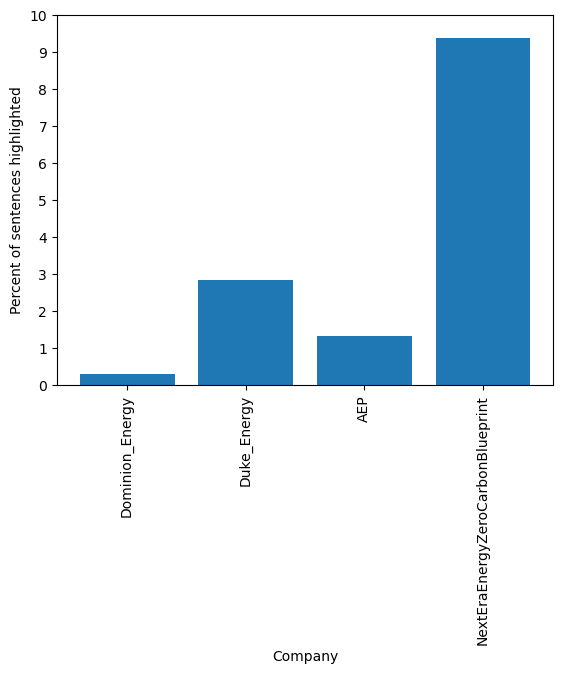

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 11, 1))
plt.show()

In [89]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    4.000000
mean     3.456641
std      4.081803
min      0.295421
25%      1.060697
50%      2.078071
75%      4.474014
max      9.375000
dtype: float64

### Exporting and Saving Files 

In [90]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

Utlities_reltext = rel_text_df
Utlities_alltext = all_text_df
Utlities_stat = final_text_stat

%store Utlities_reltext
%store Utlities_alltext
%store Utlities_stat

Stored 'Utlities_reltext' (DataFrame)
Stored 'Utlities_alltext' (DataFrame)
Stored 'Utlities_stat' (DataFrame)
